In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import datetime
import random
from scipy import stats
import math
import nbimporter
from Modelling_utils import custom_distance,custom_distance_exp,get_xCCDF,find_opt_params,funcD,funcD_noC,get_results_PL_exp

import seaborn as sns

#Avoiding Type 3 fonts in matplotlib plots
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
pd.options.display.max_rows = 4000

In [2]:
font = {'size'   : 15}

matplotlib.rc('font', **font)
matplotlib.rc('lines', linewidth=2.0)
matplotlib.rc('lines', markersize=8)

In [3]:
res='results/'

## NHTS Data reading

In [4]:
# Data reading  NHTS17 data
df_Nhts=pd.read_csv('data/trippub_2017NHTS.csv',decimal='.',sep=',',usecols=["TRPMILES", "TRPTRANS","WHYTRP1S"])
print(df_Nhts.head(2))
# Different transport modes extraction and unit conversion to Km
df_Nhts_LRpublic=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([14,19,20])==True]*1.60934
#03 is car, 18 is the rental car
df_Nhts_car=df_Nhts['TRPMILES'][df_Nhts.TRPTRANS.isin([3,18])==True]*1.60934
df_Nhts_LR=pd.concat([df_Nhts_car,df_Nhts_LRpublic])

df_vec=df_Nhts_LR.copy() # Long distance in NHTS17
min_distance=300
max_distance=5000
maxdistance=5000

# Settings of parameters for NHTS with car included
eps_range=np.arange(0.1,2,0.1)
p_range=np.arange(0.01, 0.99, 0.05)
alp_range=np.arange(1.2,2.51,0.1)

# Settings of parameters with power law truncation
# eps_range=[1]
# p_range=[0]
# alp_range=np.arange(1.1,2.51,0.05)   

# SampleSize: number of samples for generating the trips
sampleSize=50000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# create an array of all parameter combinations to consider
# error is initialized to 0 and will be replaced later on
err=[0]
combinable=[[eps,p,alp,0,0] for eps in eps_range for p in p_range for alp in alp_range for error in err] #list
print("NHTS dataset size used: ",len(df_vec))

   TRPMILES  TRPTRANS  WHYTRP1S
0     5.244         3        20
1     5.149         3         1
NHTS dataset size used:  2853


## Model Training and Storage

In [5]:
# get the max range of trip length in the error calculation
max_d=get_xCCDF(df_vec, y_value=1e-3)
print('The max range of trip length in the error calculation', max_d)
#the number of sampling points in error calculation
num=2000

The max range of trip length in the error calculation 4891.606632739999


### Our model & Power law with dynamic truncation

In [ ]:
%%time

# Call the function to start the process
result = find_opt_params(combinable, sampleSize, min_distance, maxdistance, df_vec,max_d,num)
df_com=pd.DataFrame(result)
com=df_com.values

# The lowest error and corresponding parameters to get the optimal error
idx_best=com[:,3].argmin() #error

# the results contain the value of eps,p, alpha errors and list of simulated trip length
opt_modelling=pd.DataFrame(result[idx_best])
# opt_modelling.to_pickle(res+'Optimal results of LR Modelling in NHTS17 with car.pkl')
opt_modelling.to_pickle(res+'Optimal results of Power law with dynamic truncation for LR Modelling in NHTS17 with car.pkl')

### Power law with exponential truncation

In [6]:
# Settings for NHTS
alphas=np.arange(1.01, 1.091,0.01) 
gammas=np.arange(300, 5001,80)
Ds=np.arange(300,10001,5) 

In [7]:
%%time
opt_PLE_results=get_results_PL_exp(alphas,gammas,Ds,df_vec,max_d,num)
opt_PLE_results.to_pickle(res+"Optimal power-law with exponential truncation in NHTS.pkl")

CPU times: user 4min 27s, sys: 3.2 s, total: 4min 30s
Wall time: 4min 30s


# Plotting

In [10]:
'''CCDF plots
'''
def ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d):
    fig, ax = plt.subplots(figsize=(3.54*1.5,2.83*1.5))
    colors=['#1f77b4','red','#2ca02c']
    linestyles=['solid','dashdot','dotted']
    for i,data in enumerate(datalist):
        sorted_data = np.sort(data)
        linspaced = np.linspace(0, 1, len(data), endpoint=False)
        ax.plot(sorted_data, 1-linspaced,label=labels[i],color=colors[i],linestyle=linestyles[i],rasterized=False,markersize=5,alpha=0.8,linewidth=4)

    #the optimal results for powerlaw with exponential truncation
    Fd=[0]*len(Ds)
    for idx,d in enumerate(Ds):
        for i in Ds[Ds>=d]:
            Fd[idx]+=funcD(C,i,alpha,gamma)
    ax.plot(Ds,Fd,label='Power-law [E]',color='#ff7f0e',linestyle=(0,(3,5,1,5,1,5)),rasterized=False,markersize=5,alpha=0.6,linewidth=4)

    plt.xlabel('Trip Length (km)')
    plt.ylabel('CCDF')
    leg = ax.legend(title='NHTS Long Distance',loc='upper right',alignment='left')
    
    leg.get_title().set_fontsize('15')
    
    # plt.yscale("log")
    # plt.xscale("log")
    # plt.ylim(bottom=1e-03) 
    plt.xlim(right=5e+3)  
#     plt.xlim(left=300)
#     plt.xticks([200,1000,5000],[200,1000,5000])
#     ax.xaxis.set_ticks([200,1000,2000,3000,4000,5000])
    plt.tight_layout()
    # plt.savefig(res+'CCDF_NHTS_4Lines_log.pdf', dpi=100, bbox_inches='tight')
    plt.savefig(res+'CCDF_NHTS_4Lines_normal.pdf', dpi=100, bbox_inches='tight')
    

In [8]:
'''
data and optimal parameters reading from the stored files
You can find them in the folder "results"
'''
# NHTS dataset reading
df_vec=df_Nhts_LR.copy() # Long distance in NHTS 2017
min_distance=300
max_distance=5000
df_vec=df_vec[df_vec.between(min_distance,max_distance)]

# Reading the stored optimal modelling results from file (which can be got from above Modelling part as well)
opt_model=pd.read_pickle(res+'Optimal results of LR Modelling in NHTS17 with car.pkl')
optM=np.array(opt_model)
#Optimal result, which error is the lowest
eps = optM[0,0]
p = optM[1,0]
alp = optM[2,0]
dist= optM[4,0] #optimal trips list

# power-law with our truncation
opt_model_pl=pd.read_pickle(res+'Optimal results of Power law with dynamic truncation for LR Modelling in NHTS17 with car.pkl')

optM_pl=np.array(opt_model_pl)
#Optimal result, which error is the lowest
eps_pl = optM_pl[0,0]
p_pl = optM_pl[1,0]
alp_pl = optM_pl[2,0]
dist_pl= optM_pl[4,0] #optimal trips list

print(df_vec.shape)
print("NHTS Our model: ",eps,p,alp,optM[3,0])
print("NHTS Power law [D]: ",eps_pl,p_pl,alp_pl,optM_pl[3,0])

(2853,)
NHTS Our model:  1.1 0.7100000000000001 2.500000000000001 0.12143721091073965
NHTS Power law [D]:  1 0 1.4500000000000004 0.1431686527953174


CPU times: user 1.54 s, sys: 56.2 ms, total: 1.59 s
Wall time: 976 ms


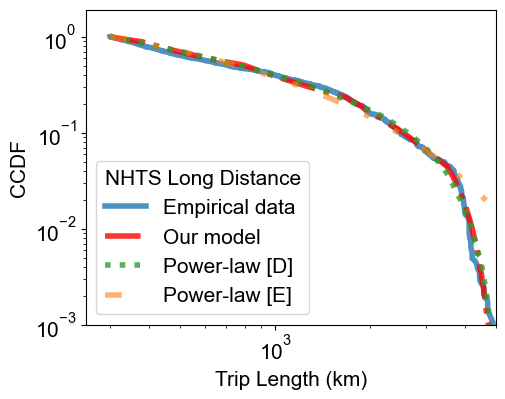

In [9]:
%%time
datalist=[df_vec,dist,dist_pl]
labels=['Empirical data','Our model','Power-law [D]']

# Reading the stored optimal power law with exponential truncation fitting parameters
opt_trunc=pd.read_pickle(res+'Optimal power-law with exponential truncation in NHTS.pkl')
#optimal alpha and gamma
alpha=opt_trunc.alpha
gamma=opt_trunc.gamma
C=opt_trunc.C
Ds=np.arange(300,10001,5) #distance trips setted

# log-log plot
ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d)

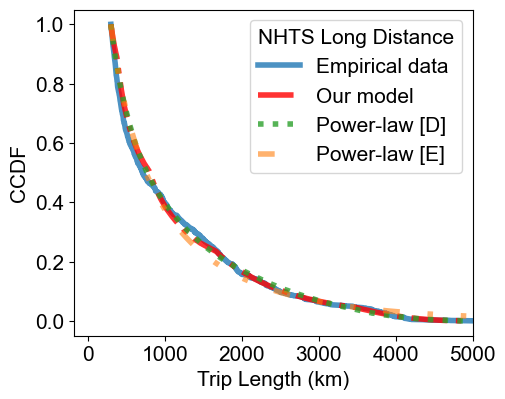

In [11]:
# normal plot
ccdf_draw(datalist,labels,Ds,C,alpha,gamma,max_d)